In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from MemSE.train_test_loop import accuracy
from MemSE.utils import count_parameters, n_vars_computation
from MemSE.model_load import load_model
from MemSE.dataset import get_dataloader
from MemSE.network_manipulations import conv_to_fc
from MemSE.MemSE import MemSE
from MemSE.MemristorQuant import MemristorQuant
from MemSE.definitions import ROOT

device = torch.device('cpu')

train_loader, valid_loader, test_loader, nclasses, input_shape = get_dataloader('CIFAR10', bs=4)
criterion = nn.CrossEntropyLoss().to(device)
model = load_model('smallest_vgg', nclasses).to(device)
print(count_parameters(model))
model = conv_to_fc(model, input_shape).to(device)
print(count_parameters(model))
batch, target = next(iter(train_loader))
batch, target = batch.to(device), target.to(device)
original_output = model(batch)
original_acc = accuracy(original_output, target)
print(f'Original acc is {original_acc}')

nvar_col, nvar_layer = n_vars_computation(model)
gmax = np.full(nvar_col, 2.)

gmax = np.load(ROOT / 'MemSE/pretrained/smallest_vgg_columnwise.npy')

quanter = MemristorQuant(model, std_noise=0.01, N=128, Gmax=gmax, wmax_mode='COLUMNWISE')
quanter.quant()
quanted_output = model(batch)
quanted_acc = accuracy(quanted_output, target)
print(f'Quanted acc is {quanted_acc}')

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading model checkpoint
4030
8061088
Original acc is [tensor(0.)]
Quanted acc is [tensor(0.)]


In [2]:
memse = MemSE(model, quanter, input_bias=None)
mses, means, varis = memse.mse_forward(batch)

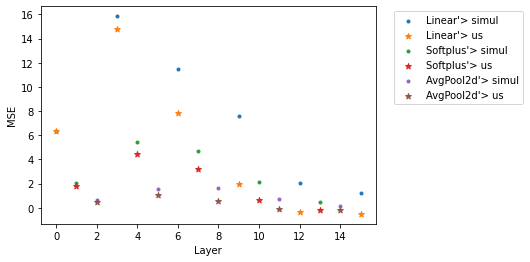

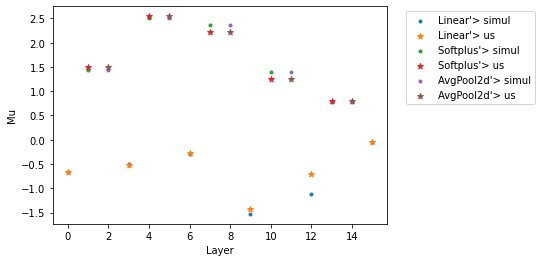

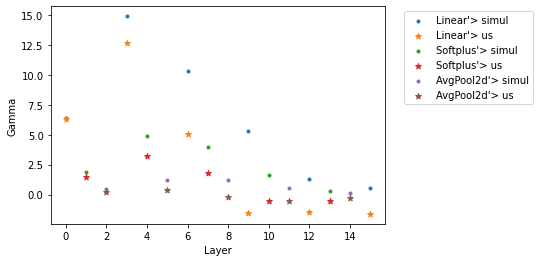

In [3]:
def plot_comp_dict(dict_, ylabel, yscale='log', legend=True):
    for type_, sub_dict in dict_['sim'].items():
        us_sub_dict = dict_['us'].get(type_)
        plt.scatter(sub_dict.keys(), sub_dict.values(), marker='.', label=str(type_).split('.')[-1]+' simul')
        plt.scatter(us_sub_dict.keys(), us_sub_dict.values(), marker='*', label=str(type_).split('.')[-1]+' us')
    if legend:
        plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
    plt.yscale(yscale)
    plt.xlabel('Layer')
    plt.ylabel(ylabel)
    plt.show()

plot_comp_dict(mses, 'MSE', 'linear')
plot_comp_dict(means, 'Mu', 'linear')
plot_comp_dict(varis, 'Gamma', 'linear')